### CNN CLASSIFICATION PROBLEM ON ROAD WITH OR WITHOUT POTHOLE

#### Getting data ready and familiarising ourselves with the data.

- The data contains images of streets in South Africa that either have potholes (positive response) or do not (negative response). The data have been split into a test and train set. The training set contains 4,026 images of test set contains 1,650 images. 

In [1]:
from IPython.display import clear_output ## for clearing output of downloads made within the notebook

### Basic dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

#### For modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
## We created a helper function that helped with lot of preprocessing and other utilities, We download it from this github repo and utilize
!wget https://raw.githubusercontent.com/IkeKobby/cnn_image_classification/main/cnn_project_preprocess.py
clear_output()

In [49]:
### import helper functions for several use.
from cnn_project_preprocess import * 

In [4]:
### Loading the training labels and the test IDs.
train_labels_path = '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/train_ids_labels.csv'
test_labels_path =  '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/test_ids_only.csv'

In [5]:
#### Getting training labels and test IDs
train_labels = get_data(train_labels_path)
test_labels = get_data(test_labels_path)

In [6]:
### View the train labels
train_labels.head(10)

,Image_ID,Label
0,cVOfkSdqnWXUerr,0
1,EhnvIDPXFFjUhkR,0
2,tYKqoStvHsryFhS,1
3,eSpjlsZIwOMLmUS,1
4,uzxhIXjNENLyHwZ,1
5,hezYtxLhHStWATz,0
6,LcZuJysTXaSNBDe,1
7,RiWvALRpGwyReTK,0
8,kYQZTGpDvwXUZlu,0
9,VxXuRhwhHDvGWty,0


In [7]:
#### View the test IDS
test_labels.head(10)

,Image_ID
0,nRhHxqLhDlJsiXc
1,gbSntVovxgHQrmO
2,nqOobGmvgEOiPms
3,oIkPTooLcIbZKlF
4,eSKxsTTJDQzkjgD
5,fGOKonqqErFfiuK
6,UZPfNzWrCgFaaNz
7,kvesbcrtTOohiLT
8,cdEZEDZaveknkKa
9,GaSSOeqyIktsAmW


In [8]:
### Checking the number of images in the respective directories
parent_dir = '/content/drive/MyDrive/KOBBY/ML and AI data/CNN'
check_image_files(parent_dir)

There are 4 directories and             2 images in '/content/drive/MyDrive/KOBBY/ML and AI data/CNN''.
There are 1 directories and             0 images in '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/all_data''.
There are 0 directories and             1100 images in '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/all_data/all_data''.
There are 0 directories and             1650 images in '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/test_data''.
There are 2 directories and             0 images in '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/validation_data''.
There are 0 directories and             285 images in '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/validation_data/pothole''.
There are 0 directories and             569 images in '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/validation_data/no_pothole''.
There are 2 directories and             0 images in '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/train_data''.
There are 0 directories and             179

- Check image files function shows the directories of our prepared data, the training set consist of 4,026 images for both class 0 and 1 and test images are 1,650.
- Our data is ready in the directories that keras._preprocessing.image_data_from_directory_  expects. `tf.keras.preprocessing.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False, smart_resize=False
)`

- We shall start with a simple classification model as our baseline and continue to improve the performance of with different approaches that best fit our classification problem.

#### Getting familiar with the dataset

Image: (600, 800, 3)


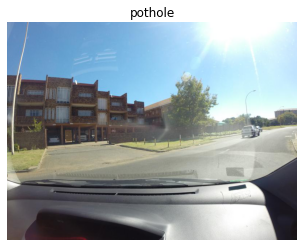

In [9]:
#### Randomly visualizing some images in the dataset
target_directory = '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/train_data'
target_class = 'pothole' ## can be changed to no_pothole to visualize from that directory
img = random_image_view(target_directory, target_class)

In [10]:
#### The array of the above image looks as follows
img

array([[[115, 140, 180],
        [117, 142, 182],
        [120, 145, 185],
        ...,
        [205, 230, 255],
        [204, 229, 255],
        [204, 229, 255]],

       [[116, 141, 181],
        [117, 142, 182],
        [120, 145, 185],
        ...,
        [205, 230, 255],
        [204, 229, 255],
        [204, 229, 255]],

       [[117, 142, 182],
        [118, 143, 183],
        [120, 145, 185],
        ...,
        [205, 230, 255],
        [204, 229, 255],
        [204, 229, 255]],

       ...,

       [[ 88,  73,  66],
        [ 89,  74,  67],
        [ 90,  75,  68],
        ...,
        [ 22,  20,  21],
        [ 21,  19,  20],
        [ 21,  19,  20]],

       [[ 87,  72,  65],
        [ 88,  73,  66],
        [ 89,  74,  67],
        ...,
        [ 22,  20,  21],
        [ 22,  20,  21],
        [ 22,  20,  21]],

       [[ 87,  72,  65],
        [ 88,  73,  66],
        [ 89,  74,  67],
        ...,
        [ 22,  20,  21],
        [ 22,  20,  21],
        [ 22,  20,  21]]

# Setting up data for our base model

> We shall use the keras ImageDataGenerator library which is built purposely for making image processing easy for various image related problems. We have organized our dataset in the format that the Generator expects, thus, a training folder containing two sub directories, each with images of the different classes of the underlying problem; in our case `pothole` and `no_pothole`. We create an instance of the library that just rescale the image tensors it reads from the disk into `0` and `1` to help with easy convergence during training of the model. \
> A short description of our dataset is the type with `4,026` training set with labels and `1,650` without labels. We splitted the training set into training and validation sets. This is to help us keep track on the model performance. It is also important to note that we had images of both test and train in a folder, after several preparation we splitted the data into the required format for the model to be trained.

#### Below is the data preparation with ImageDataGenerator and Model Creation.

In [11]:
# Set the seed
tf.random.set_seed(42)

# Setup the train and test directories
train_dir = "/content/drive/MyDrive/KOBBY/ML and AI data/CNN/train_data"
valid_dir = "/content/drive/MyDrive/KOBBY/ML and AI data/CNN/validation_data"

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)


# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)


Found 3172 images belonging to 2 classes.
Found 854 images belonging to 2 classes.


In [12]:
# We create a base CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="same"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2, padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=15,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/15
100/100 [==============================] - 1469s 15s/step - loss: 0.4345 - accuracy: 0.7935 - val_loss: 0.3129 - val_accuracy: 0.8817
Epoch 2/15
100/100 [==============================] - 166s 2s/step - loss: 0.2828 - accuracy: 0.8755 - val_loss: 0.2430 - val_accuracy: 0.8946
Epoch 3/15
100/100 [==============================] - 161s 2s/step - loss: 0.2227 - accuracy: 0.9089 - val_loss: 0.2317 - val_accuracy: 0.8993
Epoch 4/15
100/100 [==============================] - 161s 2s/step - loss: 0.1540 - accuracy: 0.9376 - val_loss: 0.1901 - val_accuracy: 0.9227
Epoch 5/15
100/100 [==============================] - 160s 2s/step - loss: 0.1332 - accuracy: 0.9511 - val_loss: 0.2184 - val_accuracy: 0.9204
Epoch 6/15
100/100 [==============================] - 165s 2s/step - loss: 0.0997 - accuracy: 0.9612 - val_loss: 0.1890 - val_accuracy: 0.9321
Epoch 7/15
100/100 [==============================] - 164s 2s/step - loss: 0.0680 - accuracy: 0.9751 - val_loss: 0.1960 - val_accuracy: 0.94

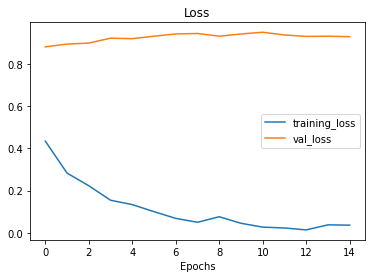

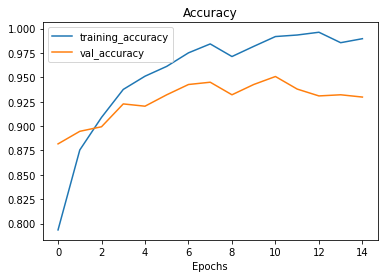

In [13]:
### Visualize the training history 
plot_training_history(history_1)

- The validation loss as it can be seen from the training is fluctuating but not increasing. However, the decrement as compared to the training loss is small and hence gives the above graphical representation above the training loss line. We shall address this issue by either tweaking our base model or perhaps generating some batches of images by augmentation to fix diversities in our validation set.

In [14]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

In [15]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [16]:
## Example of images passed into the model
images[0].shape, images[:1]

((224, 224, 3), array([[[[0.33333334, 0.46274513, 0.6313726 ],
          [0.33333334, 0.46274513, 0.6313726 ],
          [0.32941177, 0.45882356, 0.627451  ],
          ...,
          [1.        , 1.        , 1.        ],
          [0.9803922 , 1.        , 0.9960785 ],
          [0.93725497, 0.9960785 , 0.97647065]],
 
         [[0.33333334, 0.46274513, 0.6313726 ],
          [0.33333334, 0.46274513, 0.6313726 ],
          [0.33333334, 0.46274513, 0.6313726 ],
          ...,
          [1.        , 1.        , 1.        ],
          [0.97647065, 1.        , 0.9921569 ],
          [0.94117653, 1.        , 0.9803922 ]],
 
         [[0.33333334, 0.46274513, 0.6313726 ],
          [0.33333334, 0.46274513, 0.6313726 ],
          [0.3372549 , 0.4666667 , 0.63529414],
          ...,
          [1.        , 1.        , 1.        ],
          [0.9725491 , 0.9960785 , 0.98823535],
          [0.9450981 , 1.        , 0.9843138 ]],
 
         ...,
 
         [[0.24705884, 0.15686275, 0.13333334],
   

#### Making predictions with the our base model

> We shall load some images from our validation/test set, make prediction on it and if the prediction is correct we print its title in green color else in red with our facilitated `make_random_prediction` method from our helper functions imported above.

In [13]:
def check_some_predictions(model, num_preds=3):

  ### From our helper functions we shall use `make_random_prediction` to visualize how the model is performing
  ### First we give the class_names 
  class_names = ['no_pothole', 'pothole']
  ### also instanstiate the test directory 
  test_directory = '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/validation_data/'

  ### specify the number of predictions to make
  

  #### calling the prediction function
  make_random_prediction(model=model, class_names=class_names, test_dir=test_directory, num_preds=num_preds)

- Random predictions of specified images, red color indicating wrong prediction and green color indicating true prediction. 

## Making prediction on our test data
- Our test data contains `1,650` images. We shall make predictions with our trained model to classifying them into `potholes` or `no_potholes`. 

In [14]:
#### Get the directory of the test data
test_dir = '/content/drive/MyDrive/KOBBY/ML and AI data/CNN/test_data'

def make_test_preds(model, test_dir, test_labels):
  ##innitiate an empty list to collect converted images
  test_sets = []

  ## Run for loop to collect all images in the test directory
  for filename in os.listdir(test_dir):
    filepath = test_dir + '/' + filename
    test_sets.append(load_image(filepath, scale = True)) ## load_image helps convert an image into an array from our helper functions

  ### convert the list into an array
  test_data = np.array(test_sets)

  ## confirm the shape of one image suitable for the model it was trained on.
  print(test_data[0].shape)

  ## We will pass the array of images to our model to make predictions and get the labels
  preds_probas = model.predict(test_data)

  ## Since we used sigmoid activation function and that outputs a value between 0 and 1 with threshold of 0.5, we shall get the labels using either tf.round/np.round or rule based.
  #test_preds = np.round(preds_probas, 6)

  ## Next we shall append the labels to the test_ids_only data.
  test_labels['Labels'] = preds_probas
  return test_labels


In [21]:
model_1_predictions = make_test_preds(model_1, test_dir, test_labels)
model_1_predictions

(224, 224, 3)


In [22]:
### Check for the number of class distribution in the test_labels
model_1_predictions.Labels.value_counts()

1.000000    178
0.000000     35
0.999999     24
0.999998     13
0.999997     11
           ... 
0.991528      1
0.824069      1
0.987626      1
0.835283      1
0.989276      1
Name: Labels, Length: 1334, dtype: int64

In [36]:
### Next we shall save this to a csv file and check the performance of the log Loss on Zindi
#test_labels['Labels'] = np.round(preds_probas, 6) ### We save the prediction probabilties up to six (6) decimal places.
model_1_predictions.to_csv('pred_probs.csv', index= False)

> Zindi used the Log-loss metrics to evaluate the competition. Hence this model has a `logLoss` performance of `7.07985434488069`. We shall see if we can optimize this lost with the following techniques. It is worth noting that the best performance of the logloss on the leadership board is `0.258159757...`

#### Experimenting with transfer learning with Keras functional API

In [15]:
# Import data from directories and turn it into batches
trans_l_train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                          batch_size=32, # number of images to process at a time 
                                                          image_size=(224, 224), # convert all images to be 224 x 224
                                                          label_mode="binary", # type of problem we're working on
                                                          seed=42)

trans_l_valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                          batch_size=32,
                                                          image_size=(224, 224),
                                                          label_mode="binary",
                                                          seed=42)

Found 3172 files belonging to 2 classes.
Found 854 files belonging to 2 classes.


In [16]:
# Check out the class names of our dataset
trans_l_train_data.class_names

['no_pothole', 'pothole']

In [17]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_3 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



16711680/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [18]:
# 10. Fit the model (we use less steps for validation so it's faster)
history_transfer_learning = model_3.fit(trans_l_train_data,
                                 epochs=5,
                                 steps_per_epoch=len(trans_l_train_data),
                                 validation_data=trans_l_valid_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(trans_l_valid_data)))

Epoch 1/5
100/100 [==============================] - 612s 6s/step - loss: 0.5341 - accuracy: 0.7579 - val_loss: 0.3494 - val_accuracy: 0.8854
Epoch 2/5
100/100 [==============================] - 191s 2s/step - loss: 0.3931 - accuracy: 0.8531 - val_loss: 0.3103 - val_accuracy: 0.8958
Epoch 3/5
100/100 [==============================] - 193s 2s/step - loss: 0.3392 - accuracy: 0.8707 - val_loss: 0.2550 - val_accuracy: 0.9167
Epoch 4/5
100/100 [==============================] - 193s 2s/step - loss: 0.3092 - accuracy: 0.8852 - val_loss: 0.2391 - val_accuracy: 0.9167
Epoch 5/5
100/100 [==============================] - 193s 2s/step - loss: 0.2823 - accuracy: 0.8906 - val_loss: 0.2052 - val_accuracy: 0.9375


- Compared to our two models earlier the validation performance with the EfficientNet seem to be better even with the top freezed. We shall continue with fine tuning by unfreezing some layers to check the perfomance. 

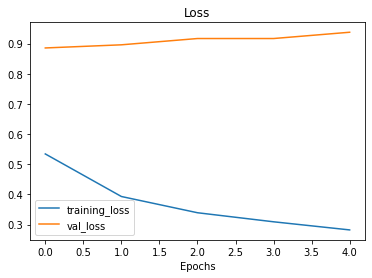

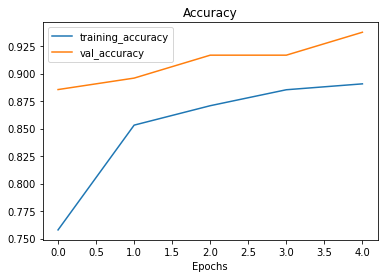

In [19]:
### Visualize the training history  for the transfer learning
plot_training_history(history_transfer_learning)

- We used a transfer learning with the top freezed and the output layer set to our binary classification. 

> Making prediction with the EfficientNet model

In [20]:
#### We use the function from above
Efficient_test_preds = make_test_preds(model_3,test_dir=test_dir, test_labels=test_labels)
Efficient_test_preds

(224, 224, 3)


,Image_ID,Labels
0,nRhHxqLhDlJsiXc,0.490752
1,gbSntVovxgHQrmO,0.491850
2,nqOobGmvgEOiPms,0.491204
3,oIkPTooLcIbZKlF,0.490113
4,eSKxsTTJDQzkjgD,0.489740
...,...,...
1645,BmSrWvzrriPuQOh,0.490577
1646,HfXCITRCHqrLOda,0.490375
1647,uQLYKtTCnvWWGVu,0.489810
1648,gYWbwjUOZrOlTzQ,0.489835


In [21]:
#### saving predictions
Efficient_test_preds.to_csv('efficient.csv', index = False)

- After zindi submission on the performance of EfficientNet, we observed that we have improved by this `0.73468666095937` much of logloss compared to our earlier `7.07985434488069`. 

#### We shall unfreeze some layers to give chance to the model to train.

In [22]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

- It's seen that all the layers not training. We shall unfreeze the last `10` layers to see the performance.

In [23]:
#### We set all the layers to train.
base_model.trainable = True
0.73468666095937
# Freeze all layers except for the last 10 layers
for layer in base_model.layers[:-8]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_3.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [24]:
print(len(model_3.trainable_variables)) ### We have got 12 layers training now.

12


In [25]:
# Fine tune for another epochs
fine_tune_epochs = 5

# Refit the model (same as model_2 except with more trainable layers)
history_transfer_learning_fine_tuned = model_3.fit(trans_l_train_data,
                                               epochs=fine_tune_epochs,
                                               validation_data=trans_l_valid_data,
                                               validation_steps=int(0.25 * len(trans_l_valid_data)))

Epoch 1/5
100/100 [==============================] - 199s 2s/step - loss: 0.2397 - accuracy: 0.9079 - val_loss: 0.1554 - val_accuracy: 0.9323
Epoch 2/5
100/100 [==============================] - 191s 2s/step - loss: 0.1903 - accuracy: 0.9284 - val_loss: 0.1517 - val_accuracy: 0.9271
Epoch 3/5
100/100 [==============================] - 191s 2s/step - loss: 0.1535 - accuracy: 0.9461 - val_loss: 0.1334 - val_accuracy: 0.9427
Epoch 4/5
100/100 [==============================] - 191s 2s/step - loss: 0.1337 - accuracy: 0.9530 - val_loss: 0.1017 - val_accuracy: 0.9635
Epoch 5/5
100/100 [==============================] - 191s 2s/step - loss: 0.1183 - accuracy: 0.9590 - val_loss: 0.0679 - val_accuracy: 0.9792


- EfficientNet with 12 training layers sees so far a good performance on the validation loss as compared to the previous models and techniques.Although, there are a bit of fluctuation in the decreasing nature of the losses. However, the model trains as expected with a consistent loss reduction
- We shall make predictions and see the performance for this results. 

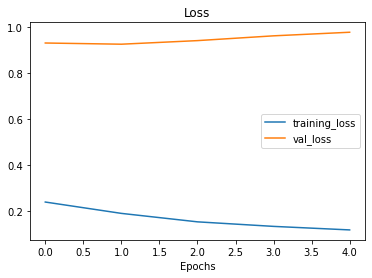

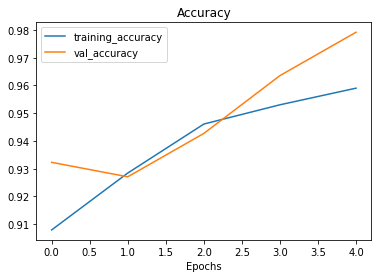

In [26]:
### Visualize the training history  for the transfer learning
plot_training_history(history_transfer_learning_fine_tuned)

In [27]:
#### We use the function from above
EfficientNet_Unfreeze_test_preds = make_test_preds(model_3,test_dir=test_dir, test_labels=test_labels)
EfficientNet_Unfreeze_test_preds

(224, 224, 3)


,Image_ID,Labels
0,nRhHxqLhDlJsiXc,0.545425
1,gbSntVovxgHQrmO,0.546513
2,nqOobGmvgEOiPms,0.545986
3,oIkPTooLcIbZKlF,0.545405
4,eSKxsTTJDQzkjgD,0.544927
...,...,...
1645,BmSrWvzrriPuQOh,0.545902
1646,HfXCITRCHqrLOda,0.545260
1647,uQLYKtTCnvWWGVu,0.544764
1648,gYWbwjUOZrOlTzQ,0.545179


In [28]:
#### saving predictions
EfficientNet_Unfreeze_test_preds.to_csv('efficientnet_unfreezed.csv', index = False)

### Conclusion 
- In conclusion, we have experimented on three different models to evaluate and conclude on the best model and performance. We face a little challenge, not necessarily challenge though but spending lots of time on the image processing to get it ready for the model. As a result of this we wrote a few python scripts as helper functions named `cnn_project_preprocess.py` to facilitate our experiments. 
- We trained the model on the `3,172` images and validated on `845` images. Our test data contained `1,650` images without labels to be determined by the trained model with prediction probabilities on the Zindi submission portal. We ran several experimented and as per the performance received from the submission portal we tried to beat it using different techniques. 
- We finally, consulted to transfer learning with the `EfficientNet` architecture. Compared to all models ran the transfer learning gave a better performance with the `logloss` evaluation metrics on the Zindi platform. 

- In conclusion the good score we got for the logloss is `0.68923783763495`.